# R5.C.08 - Analyse de données : ACP, AFC

## 1. Codesource, fichier(s) de données ou un lien de récupération


Le code source et le jeu de données sont disponibles sur GitHub :
- [https://github.com/Arcthuruss/Glue-factory-analysis](https://github.com/Arcthuruss/Glue-factory-analysis)
**Instruction** : Git LFS est requis pour cloner le dépôt car le jeu de données est volumineux (=448Mo).

---

## 2. Introduction, constitution du groupe

Le projet consiste à analyser un jeu de données de notre choix en utilisant des techniques d'analyse de données vues lors de la ressource R5.C.08 - Techniques d'intelligence artificielle.
Avec pour objectif de pratiquer les techniques d'ACP (Analyse en Composantes Principales) et d'AFC (Analyse Factorielle des Correspondances) sur des variables quantitatives et qualitatives respectivement.

Le projet a été réalisé par un groupe de deux personnes :
- DONNARD Luc
- NÉVOT Pierre

---

## 3. Description du jeu de données

Le jeu de données provient de Kaggle : [https://www.kaggle.com/datasets/takamotoki/jra-horse-racing-dataset](https://www.kaggle.com/datasets/takamotoki/jra-horse-racing-dataset)

Il contient plusieurs csv tel que :
- 19860105-20210731_laptime.csv qui contient les données des tours de chaque course entre 1986 et 2021
- 19860105-20210731_odds.csv qui contient les cotes des chevaux pour chaque course entre 1986 et 2021
- 19860105-20210731_race_results.csv qui contient les résultats de chaque course entre 1986 et 2021
- 20020615-20210731_corner_passing_order.csv qui contient les positions des chevaux à chaque virage entre 2002 et 2021

On a choisi d'utiliser 19860105-20210731_race_results.csv car il contient des informations sur le resultat du cheval gagnant ainsi que pleins d'informations sur la course.
Le dataset contient au minimun 1 554 146 entrées et 66 colonnes au total.

En voici les principales variables :
- Turf and Dirt Category : Catégorie de la piste (herbe ou terre)
- Clockwise And Anti-clockwise and Straight Course Category : Catégorie de la course (sens horaire, antihoraire ou ligne droite)
- Distance(m) : Distance de la course en mètres
- Weather : Conditions météorologiques
- Track Condition1 : État de la piste
- Final Position : Position finale du cheval
- Bracket Number : Numéro de la série
- Post Position : Position de départ
- Horse Name : Nom du cheval
- Age : Âge du cheval
- Jockey : Nom du jockey
- Total Time(1/10s) : Temps total en dixièmes de seconde
- Position 3rd Corner : Position au 3ème virage
- Position 4th Corner : Position au 4ème virage
- Win Odds(100Yen) : Cote de victoire (en 100 Yen)
- Win Fav : Favori à la victoire

Le contexte est l'analyse des courses de chevaux au Japon, en utilisant des données historiques pour identifier des tendances et des facteurs influençant les résultats des courses.

---

## 4. Nettoyage de données

On a retiré les colonnes non pertinentes qui contenaient des valeurs non pertinentes et incomplètes.
On a ensuite traduit les attributs importants du japonais vers l'anglais pour faciliter l'analyse.
Tel que le type de course, si la course est dans le sens des aiguilles d'une montre ou non, la météo, l'état de la piste.
A part cela le dataset étant propre on a 1 554 146 entrées de données complètes.

In [ ]:
# imports du projet
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

time_str_to_ms = lambda time_as_str : [(int(i[0])*600 + int(i[1])*10 + int(i[2])) for i in [i.replace(':', ' ').replace('.', ' ').split(' ') for i in time_as_str]]

In [ ]:
# filter script

input_file = "./datasets/19860105-20210731_race_result.csv"
output_file = "./clean_datasets/filtered_race_result.csv"

# Ligne qui va être supprimée (pas de nom de colonne car le header est en japonais et prendrais trop de temps)
positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 40, 41, 43, 47, 49, 52, 53, 54, 57, 60, 61, 62, 63, 64, 65]

with open(input_file, newline='', encoding='utf-8') as infile, \
    open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    for row in reader:
        filtered_row = [col for i, col in enumerate(row) if i not in positions]
        if all(filtered_row):
            writer.writerow(filtered_row)

# Remplace le header par le header en anglais
with open(output_file, 'r', newline='', encoding='utf-8') as infile:
    lines = infile.readlines()
header = "Turf and Dirt Category,Clockwise And Anti-clockwise and Straight Course Category,Distance(m),Weather,Track Condition1,Final Position,Bracket Number,Post Position,Horse Name,Age,Jockey,Total Time(1/10s),Position 3rd Corner,Position 4th Corner,Win Odds(100Yen),Win Fav"
lines[0] = header + "\n"
with open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    outfile.writelines(lines)


In [ ]:
# Traduit les noms propres jopnais en anglais

# Fonction pour charger le cache
def load_cache(cache_file):
    try:
        with open(cache_file, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        return {}

# Fonction pour sauvegarder le cache
def save_cache(cache, cache_file):
    with open(cache_file, 'w', encoding='utf-8') as f:
        json.dump(cache, f, ensure_ascii=False, indent=4)

# Si la valeur n'est pas dans le cache, demande la traduction
def ask_translation(text):
    print(f"Traduction pour '{text}': ", end="")
    return input().strip()

def annotate_csv(input_file, output_file, cache_file='translation_cache.json'):
    cache = load_cache(cache_file)
    df = pd.read_csv(input_file)

    # Ne traiter que les 5 premières colonnes
    cols_to_check = df.columns[:5]

    for col in cols_to_check:
        for i, value in enumerate(df[col]):
            if pd.isna(value):
                continue
            # Vérifier si la valeur est du texte japonais et non déjà dans le cache
            if value not in cache and any('\u3040' <= char <= '\u30ff' or '\u4e00' <= char <= '\u9faf' for char in str(value)):
                translation = ask_translation(value)
                cache[value] = translation

    save_cache(cache, cache_file)

def replace_with_cache(df, cache):
    for col in df.columns[:5]:
        df[col] = df[col].apply(lambda x: cache.get(x, x) if pd.notna(x) else x)
    return df

input_file = "./clean_datasets/filtered_race_result.csv"
output_file = "./clean_datasets/translated_race_result.csv"
annotate_csv(input_file, output_file)
cache = load_cache('translation_cache.json')
df = pd.read_csv(input_file)
df = replace_with_cache(df, cache)
df.to_csv(output_file, index=False)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1150145917.py, line 29)

In [ ]:
translated_file = "./clean_datasets/translated_race_result.csv"
df = pd.read_csv(translated_file)

---

## 5. Variables quantitatives : ACP

### 5.1 Standardisation












In [ ]:
distance = df.iloc[:, 2].values
final_position = df.iloc[:, 5].values
bracket_number = df.iloc[:, 6].values
post_position = df.iloc[:, 7].values
age = df.iloc[:, 9].values
third_corner_position = df.iloc[:, 12].values
fourth_corner_position = df.iloc[:, 13].values
win_odds = df.iloc[:, 14].values
win_fav = df.iloc[:, 15].values


### 5.2 Entraînement du modèle

Effectuez une ACP (Analyse en Composantes Principales) sur les données standardisées.

In [ ]:
pca = PCA(n_components=2)
print(pca.fit_transform(final_position))

NameError: name 'final_position' is not defined

### 5.3 Choix du nombre de composantes principales

Expliquez le critère de choix (ex : seuil de variance expliquée).

### 5.4 Tableau de valeurs singulières + % variance

Présentez un tableau avec les valeurs propres et le pourcentage de variance expliquée par chaque composante.

### 5.5 Visualisation des variables avec biplot, étude sur la corrélation entre variables

Affichez un biplot et commentez la corrélation entre variables.

### 5.6 Visualisation des individus avec le plan factoriel

Projetez les individus sur le plan des deux premières composantes principales.

---

## 6. Variables qualitatives : AFC

### 6.1 Choix de deux variables, tableau de contingence

Je choisit les variables "Weather" (météo)", "Track Condition1". Pour analyser la relation entre les conditions météorologiques et l'état de la piste.
On a retirer "Clear" car c'est une anomalie dans les données qui répresente 37 entrées sur 1 554 146.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.decomposition import FactorAnalysis, PCA
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# Charger les données
data = pd.read_csv('./clean_datasets/translated_race_result.csv')
# On garde les colonnes qui ne sont pas Weather et Track Condition1
data = data[['Weather', 'Track Condition1']]
data = data.dropna()
data = data.astype(str)

# Tableau de contingence
contingency_table = pd.crosstab(data['Weather'], data['Track Condition1'])
print("Tableau de contingence entre Weather et Track Condition1:")
print(contingency_table)
print()

# "Clear" est une anomalie dans les données donc on la retire
contingency_table = contingency_table.drop(index='Clear', errors='ignore')
print("Tableau de contingence entre Weather et Track Condition1:")
print(contingency_table)

Tableau de contingence entre Weather et Track Condition1:
Track Condition1    Bad    Good  Heavy  Slightly Heavy
Weather                                               
Clear                16      21      0               0
Clear Sky         16080  777420  52203           96163
Cloudy            32916  299726  49105           80919
Light Rain         8020   25520   8021           13511
Light Snow            9     683     41             499
Rain              28278   21666  17161           24619
Snow                341     736    143             329

Tableau de contingence entre Weather et Track Condition1:
Track Condition1    Bad    Good  Heavy  Slightly Heavy
Weather                                               
Clear Sky         16080  777420  52203           96163
Cloudy            32916  299726  49105           80919
Light Rain         8020   25520   8021           13511
Light Snow            9     683     41             499
Rain              28278   21666  17161           24619
Sno

### 6.2 Test de sphéricité de Bartlett/Test de Chi2, conclusion sur la corrélation

In [3]:
# Test du Chi2
from scipy.stats import chi2_contingency
chi2, pval, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2: {chi2}, p-value: {pval}, dof: {dof}, expected: {expected}")

Chi2: 251533.3541390435, p-value: 0.0, dof: 15, expected: [[5.19044492e+04 6.82260119e+05 7.67706343e+04 1.30930797e+05]
 [2.54966459e+04 3.35141687e+05 3.77114816e+04 6.43161854e+04]
 [3.03491349e+03 3.98925423e+04 4.48886824e+03 7.65567594e+03]
 [6.78931838e+01 8.92424683e+02 1.00419191e+02 1.71262942e+02]
 [5.05473571e+03 6.64421767e+04 7.47633916e+03 1.27507485e+04]
 [8.53624527e+01 1.12205019e+03 1.26257570e+02 2.15329787e+02]]


On obtient un p-value très faible (inférieur à 0.05), ce qui indique que nous rejetons l'hypothèse nulle d'indépendance entre les deux variables. On peut donc réaliser une AFC sur les deux variables.

### 6.3 Standardisation

In [7]:
# Standardisation
temp = contingency_table.sub(contingency_table.mean())
X_scaled = temp.div(contingency_table.std())

print("Valeurs du tableau de contingence standardisé:")
print(X_scaled)
print()

X2_val, p_val = calculate_bartlett_sphericity(X_scaled)
print("Résultats du test de sphéricité de Bartlett:")
print(X2_val, p_val)

Valeurs du tableau de contingence standardisé:
Track Condition1       Bad      Good     Heavy  Slightly Heavy
Weather                                                       
Clear Sky         0.128762  1.895437  1.308938        1.433487
Cloudy            1.329113  0.360261  1.178510        1.070232
Light Rain       -0.445889 -0.520961 -0.551154       -0.536057
Light Snow       -1.017047 -0.600780 -0.887117       -0.846125
Rain              0.998439 -0.533347 -0.166354       -0.271361
Snow             -0.993377 -0.600610 -0.882823       -0.850176

Résultats du test de sphéricité de Bartlett:
37.36645254536308 1.4936884404410852e-06


La standardisation est importante pour l'AFC car elle permet de mettre les variables sur une échelle comparable, en éliminant les effets de l'échelle et en facilitant l'interprétation des résultats. 

La p-value du test de sphéricité de Bartlett indique que les variables sont corrélées, ce qui justifie l'utilisation de l'AFC.

Dans notre cas le tableau de contingence standardisé montre les écarts par rapport à la moyenne en termes d'écart-type pour chaque combinaison de conditions météorologiques et d'état de la piste. Par exemple, pour les jours de "Clear Sky" (ciel clair), on observe des valeurs standardisées positives pour toutes les conditions de piste, indiquant que ces combinaisons sont plus fréquentes que la moyenne. En revanche, pour les jours de "Light Snow" (légère neige), les valeurs sont négatives, suggérant que ces combinaisons sont moins fréquentes que la moyenne.

### 6.4 Entraînement du modèle FactorAnalyzer

In [22]:
# Factor Analysis
contingency_table.shape
n_max_factors = min(contingency_table.shape[0] - 1, contingency_table.shape[1] - 1)
print(f"Nombre maximum de facteurs: {n_max_factors}")
print()

fa = FactorAnalyzer(n_factors = n_max_factors, rotation = None)
fa.fit(X_scaled)
ev, v = fa.get_eigenvalues()
fa_res = fa.loadings_
print(fa_res)
print()

fa_new = FactorAnalysis(n_components=n_max_factors, random_state=0)
X_transformed = fa_new.fit_transform(X_scaled)
print(fa_new.components_)
print()

print("Représentation du premier tableau de facteurs:")
columns = ["col_" + str(i + 1) for i in range(n_max_factors)]
df_factors = pd.DataFrame(fa.loadings_, columns= columns, index = X_scaled.columns)
df_factors.head()

Nombre maximum de facteurs: 3

[[ 0.72159267  0.67655253  0.05320545]
 [ 0.87934544 -0.46281127  0.08709726]
 [ 0.99671748  0.0039898  -0.06231593]
 [ 0.99369225 -0.08574191 -0.05320548]]

[[ 6.25247509e-01  8.14433079e-01  9.11713071e-01  9.12114932e-01]
 [-6.31547859e-01  4.02332218e-01 -4.57842846e-02  3.69241284e-02]
 [ 1.97152911e-01  8.39018263e-02 -1.19613984e-05 -1.36986394e-03]]

Représentation du premier tableau de facteurs:


C:\Users\alias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,col_1,col_2,col_3
Track Condition1,,,
Bad,0.721593,0.676553,0.053205
Good,0.879345,-0.462811,0.087097
Heavy,0.996717,0.003990,-0.062316
Slightly Heavy,0.993692,-0.085742,-0.053205


On fait notre étude sur 3 facteurs.

Avec le premier tableau, de facteurs, on peut en sortir plusieurs informations.
La première colonne montre que la première composante est fortement corrélée avec toutes les conditions de piste, donc on peut supposer que la condition de la piste est lié à la météo.

La deuxième colonne montre que la deuxième composante est distincte avec Light Snow et Light Rain, donc on peut supposer que ces deux conditions météorologiques ont un impact différent sur l'état de la piste par rapport aux autres conditions.

La troisième colonne montre des valeurs proches de zéro, indiquant que cette composante n'apporte pas d'information significative.

Avec le second tableau, de composantes principales, on peut en tirer plusieurs informations.
[[ 6.25247509e-01  8.14433079e-01  9.11713071e-01  9.12114932e-01]
 [-6.31547859e-01  4.02332218e-01 -4.57842846e-02  3.69241284e-02]
 [ 1.97152911e-01  8.39018263e-02 -1.19613984e-05 -1.36986394e-03]]

La première ligne montre que les bonnes conditions de pistes sont associées à un ciel clair donc inversement on peut déduire que les mauvaises conditions de pistes sont associées à des conditions météorologiques défavorables.

La deuxième ligne montre qu'il y a un contraste entre les différentes conditions météorologiques, en particulier entre "Light Snow" et "Light Rain" par rapport aux autres conditions.

La troisième ligne montre des valeurs proches de zéro, indiquant que cette composante n'apporte pas d'information significative.

### 6.5 ScreePlot pour les valeurs propres de facteurs

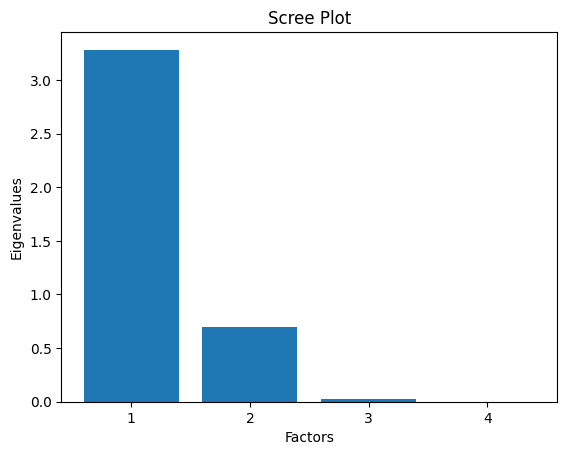

In [23]:
# Visualisation des facteurs
fig, ax = plt.subplots()
labels = [str(i+1).zfill(1) for i in range(len(ev))]
ax.bar(labels, ev, label = labels)
ax.set_xlabel("Factors")
ax.set_ylabel("Eigenvalues")
plt.title("Scree Plot")
plt.show()

Comme dit précédemment, on peut voir que la première composante explique une grande partie de la variance, la deuxième en explique une partie significative, et la troisième n'apporte pas d'information significative.


### 6.6 Graphiques sur 3 rotations différentes

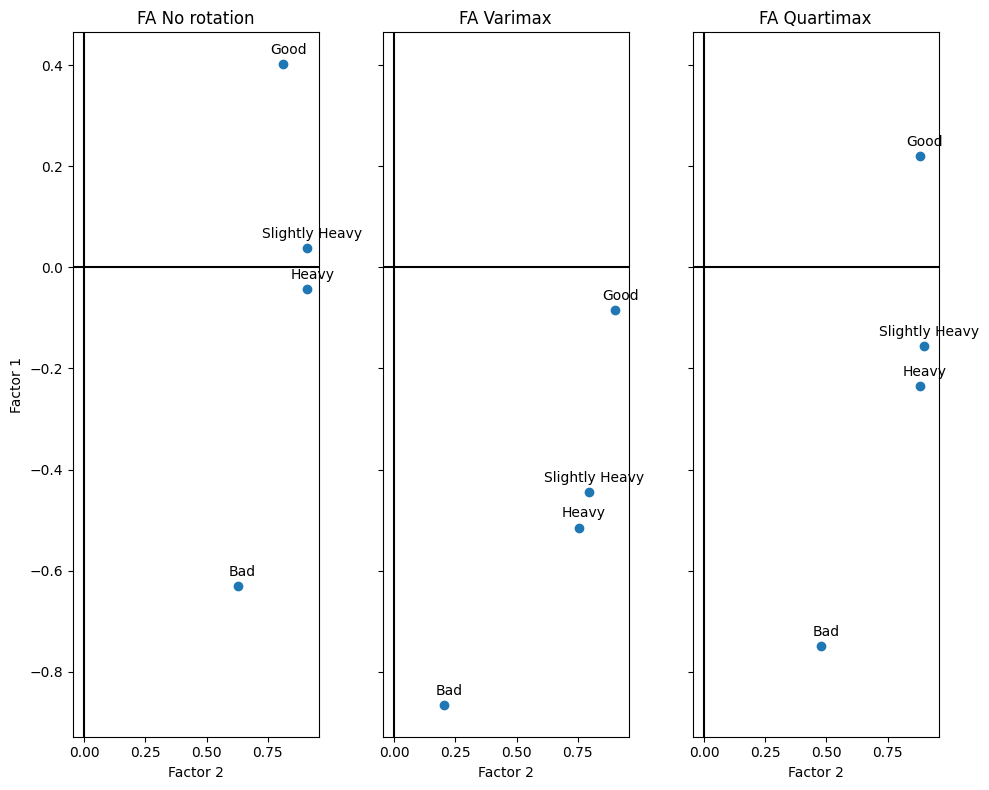

In [24]:
# Utiliser FactorAnalysis de scikitlearn
methods = [
    ("FA No rotation", FactorAnalysis(2,)),
    ("FA Varimax", FactorAnalysis(2, rotation="varimax")),
    ("FA Quartimax", FactorAnalysis(2, rotation="quartimax")),
]
fig, axes = plt.subplots(ncols=3, figsize=(10, 8), sharex=True, sharey=True)

for ax, (method, fa) in zip(axes, methods):
    fa = fa.fit(X_scaled)

    components = fa.components_
    ax.scatter(components[0,:], components[1, :])
    ax.axhline(0, -1, 1, color='k')
    ax.axvline(0, -1, 1, color='k')
    for i,j, z in zip(components[0, :], components[1, :], X_scaled.columns):
        ax.text(i+.02, j+.02, str(z), ha="center")
    ax.set_title(str(method))
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Factor 1")
    ax.set_xlabel("Factor 2")

plt.tight_layout()
plt.show()

#### Questions du TD2

##### Quelles sont les variables corrélées ?

Les variables corrélées identifiées à partir de l'analyse factorielle comprennent :
- Entre "Good" et "Bad" - Corrélation négative ce qui veut dire que lorsque la piste est en bonne condition, elle n'est pas en mauvaise condition et vice versa.
- Entre "Heavy" et "Slightly Heavy" - Corrélation positive ce qui veut dire que lorsque la piste est en condition "Heavy", elle est aussi en condition "Slightly Heavy" et inversement.

##### A partir de ces corrélations, pourriez-vous trouver le sens de chaque facteur ?
- Le premier facteur semble représenter une dimension de "Condition de la piste", où des valeurs élevées indiquent des conditions de piste plus favorables (Good, Slightly Heavy) et des valeurs faibles indiquent des conditions moins favorables (Bad, Heavy).
- Le deuxième facteur semble représenter une dimension de "Type de dégradation de la piste", où on distingue les pistes "Slightly Heavy" des pistes "Heavy" ou "Bad". Comme un contraste entre les conditions intermédiaires et extrêmes.

---

## 7. Explications, interprétations

---

## 8. Conclusion, déclaration d'utilisation des outils de l'IA générative